#Step 1: Pip Install and Import Libraries

##1a) Import Data Manipulation Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#Install TALIB---------------------------------------------------------
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install

# !pip install Ta-Lib
import talib as ta


import pyfolio as pf
import yfinance as yf

/tmp/ipykernel_43983/1103702075.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
/home/khaled/mambaforge/envs/perso/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(




---



#Step 2: Import Dataset & Plot

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2022-01-03,301.209991
2022-01-04,292.899994
2022-01-05,276.040009
2022-01-06,281.779999
2022-01-07,272.470001
...,...
2023-09-14,455.809998
2023-09-15,439.000000
2023-09-18,439.660004


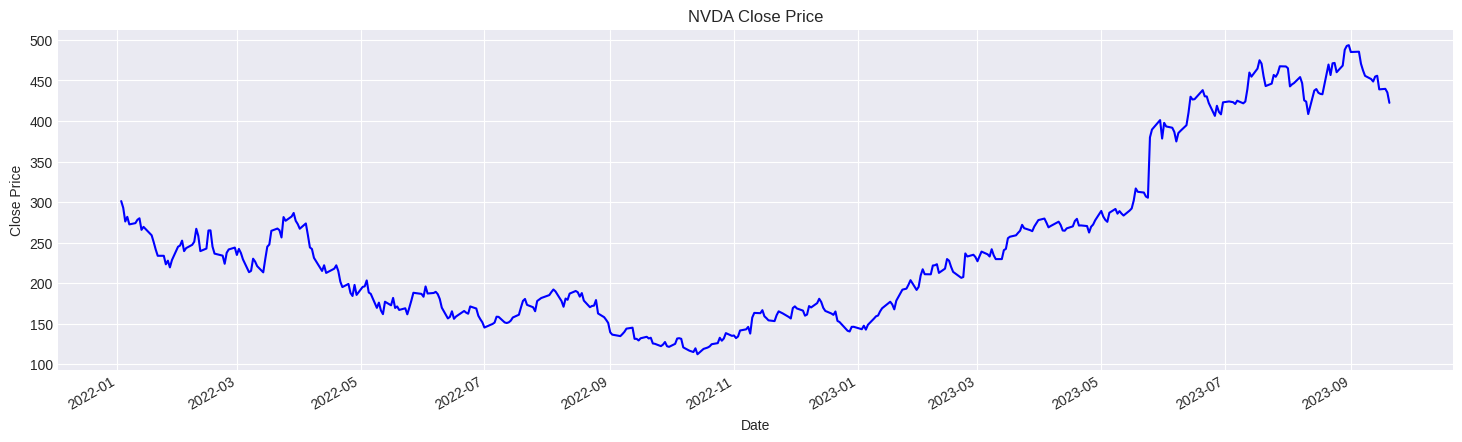

In [3]:
ticker = 'NVDA'
data = yf.download(ticker,start='2022-01-01')

#we only want the Close price
data = pd.DataFrame(data['Close'])
display(data)

#Plot---------------------------------------
data.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()



---



#Step 3: Create a Function to Define Features and Target

Mission:
- we are trying to define X to predict y
- y is the Stock Close Price
- X will contain arbitary features defined by us that we believe can be used as indicators to predict y  
- later on, we will use X and y to train the Logistic Regression Model to assist with the prediction

In [4]:
def get_target_features(data):

    # -------------------------------------------------------------
    # Define Features (X)
    #Volatility
    #(we use the pct_change() to get the Volatility)
    data['PCT_CHANGE'] = data['Close'].pct_change()
    data['VOLATILITY'] = data.rolling(14)['PCT_CHANGE'].std()*100

    #Correlation
    #(we use the SMA to get the CORR)
    data['SMA'] = ta.SMA(data['Close'],14)
    data['CORR'] = ta.CORREL(data['Close'], data['SMA'], 14)

    #RSI (unused)
    #data['RSI'] = ta.RSI(data['Close'].values, timeperiod=14)

    #ADX (unused)
    #data['ADX'] = ta.ADX(data['High'].values, data['Low'].values, data['Open'].values, timeperiod=14)


    # ------------------------------------------------------------
    # Define Target (y)
    data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)

    # Create the signal column
    data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)

    data = data.dropna()

    return data['Actual_Signal'], data[['VOLATILITY', 'CORR']]


##Features, X: Volatility & Correlation

###1) PCT_CHANGE(): (we use it to get Volatility)
- (current value — previous value) / previous value * 100
- Basically, it tells us how today is performing compared to yesterday.
- "if u had bought YESETERDAY, this would have been your returns TODAY..."

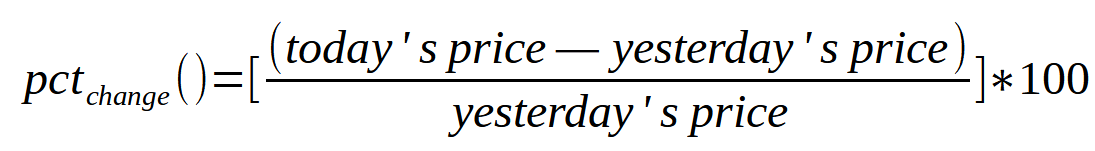

,Close,PCT_CHANGE
Date,,
2022-01-03,301.209991,NaN
2022-01-04,292.899994,-0.027589
2022-01-05,276.040009,-0.057562
2022-01-06,281.779999,0.020794
2022-01-07,272.470001,-0.033040
...,...,...
2023-09-14,455.809998,0.002111
2023-09-15,439.000000,-0.036879
2023-09-18,439.660004,0.001503


<Axes: xlabel='Date'>

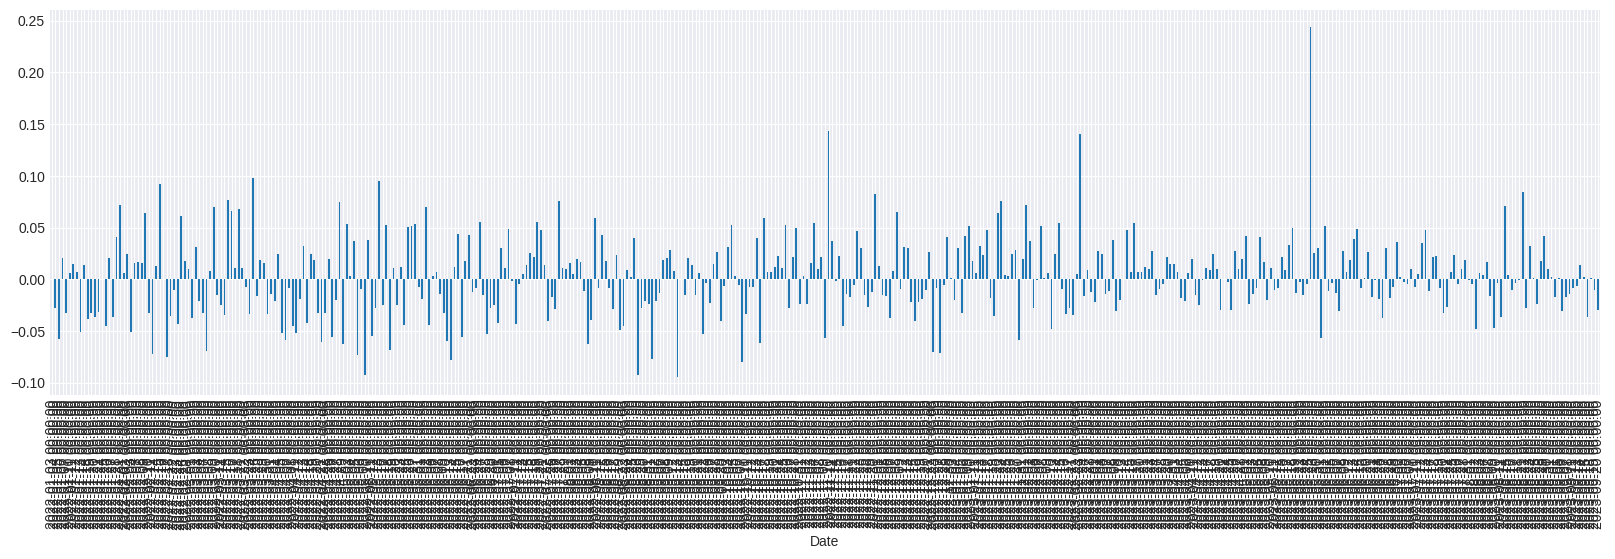

In [5]:
data['PCT_CHANGE'] = data['Close'].pct_change()
display(data)
#notice a new column "pct_change" has been created

data['PCT_CHANGE'].plot(kind='bar', figsize=(20,5))



---



###2) Volatility

- Volatility is measured by the standard deviation of the asset over a given period of time.
- The higher the standard deviation, the higher the volatility.

- In general, a volatility of 10% or less is considered to be low
- A volatility of 20% or more is considered to be high.

,Close,PCT_CHANGE,VOLATILITY
Date,,,
2022-01-03,301.209991,NaN,NaN
2022-01-04,292.899994,-0.027589,NaN
2022-01-05,276.040009,-0.057562,NaN
2022-01-06,281.779999,0.020794,NaN
2022-01-07,272.470001,-0.033040,NaN
...,...,...,...
2023-09-14,455.809998,0.002111,1.906214
2023-09-15,439.000000,-0.036879,2.042995
2023-09-18,439.660004,0.001503,1.959447


<Axes: xlabel='Date'>

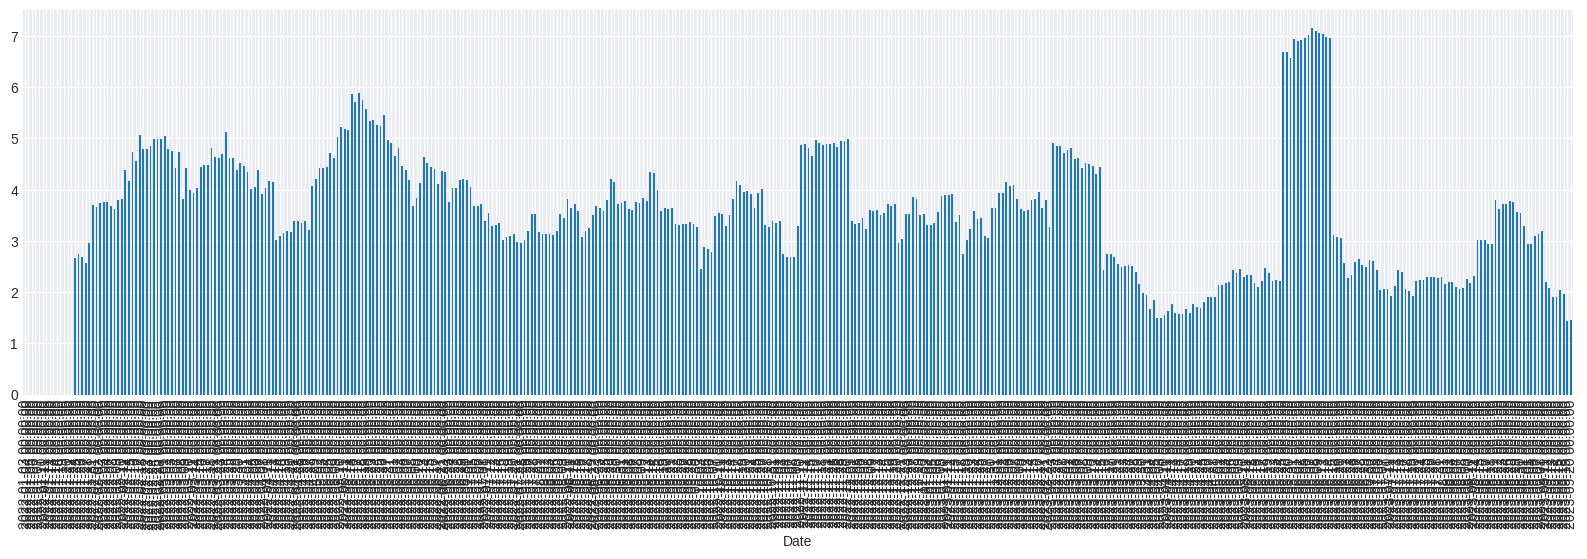

In [6]:
data['VOLATILITY'] = data.rolling(14)['PCT_CHANGE'].std()*100
display(data)
#notice a new column "volatility" has been created

data['VOLATILITY'].plot(kind='bar', figsize=(20,5))
#perhaps we should only buy when there's great volatility?



---



###3) SMA (we use the SMA to get the Corr)

How does SMA work?

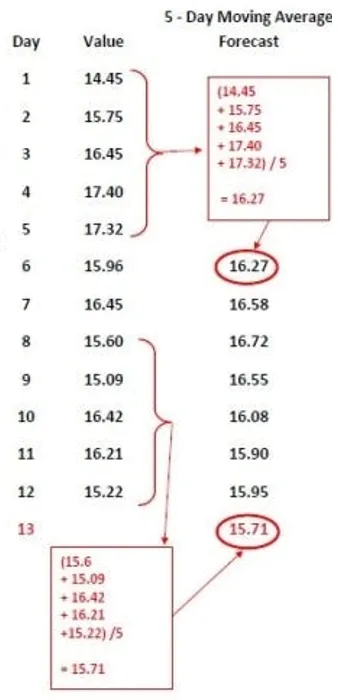

,Close,PCT_CHANGE,VOLATILITY,SMA
Date,,,,
2022-01-03,301.209991,NaN,NaN,NaN
2022-01-04,292.899994,-0.027589,NaN,NaN
2022-01-05,276.040009,-0.057562,NaN,NaN
2022-01-06,281.779999,0.020794,NaN,NaN
2022-01-07,272.470001,-0.033040,NaN,NaN
...,...,...,...,...
2023-09-14,455.809998,0.002111,1.906214,469.500715
2023-09-15,439.000000,-0.036879,2.042995,467.987858
2023-09-18,439.660004,0.001503,1.959447,465.938572


<Axes: xlabel='Date'>

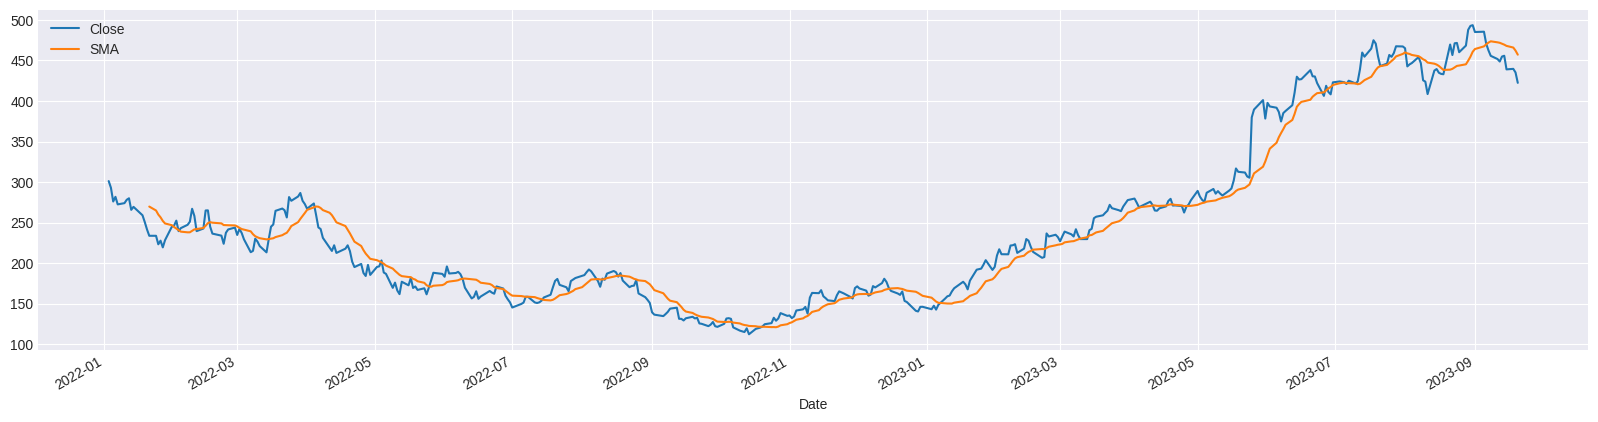

In [7]:
data['SMA'] = ta.SMA(data['Close'],14)
display(data)


data[['Close', 'SMA']].plot(figsize=(20,5))



---



###4) Correlation

- Correlation coefficient is between -1 and 1.
- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation.

- The corr function calculates the correlation between 'Close' and 'SMA' over a window of 14 days.

,Close,PCT_CHANGE,VOLATILITY,SMA,CORR
Date,,,,,
2022-01-03,301.209991,NaN,NaN,NaN,NaN
2022-01-04,292.899994,-0.027589,NaN,NaN,NaN
2022-01-05,276.040009,-0.057562,NaN,NaN,NaN
2022-01-06,281.779999,0.020794,NaN,NaN,NaN
2022-01-07,272.470001,-0.033040,NaN,NaN,NaN
...,...,...,...,...,...
2023-09-14,455.809998,0.002111,1.906214,469.500715,-0.427138
2023-09-15,439.000000,-0.036879,2.042995,467.987858,-0.587061
2023-09-18,439.660004,0.001503,1.959447,465.938572,-0.682299


<Axes: xlabel='Date'>

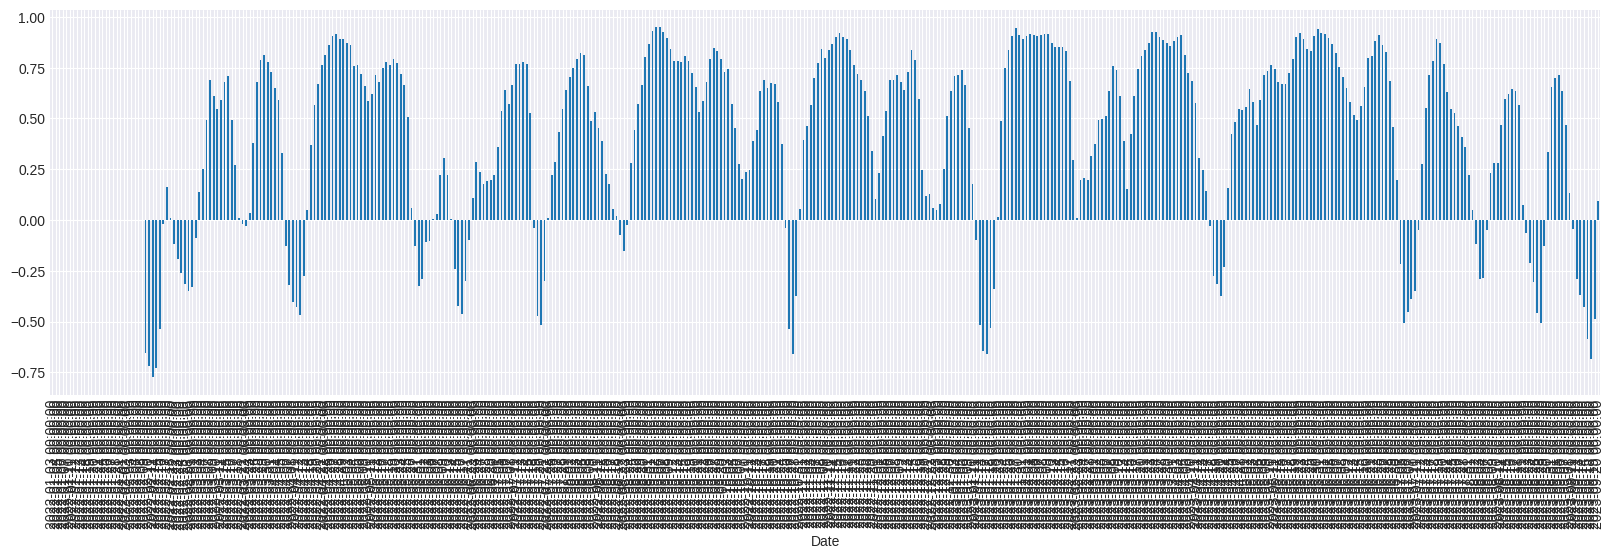

In [8]:
data['CORR'] = ta.CORREL(data['Close'], data['SMA'], 14)
display(data)

data['CORR'].plot(kind='bar', figsize=(20,5))

#SMA and the Close price is supposed to move together,
#but u can see that sometimes it doesn't.
#perhaps when there's -ve correlation, we shouldn't buy?



---



##Target, y: Returns for Tomorrow & Signal

###1) Returns 4 Tmrw

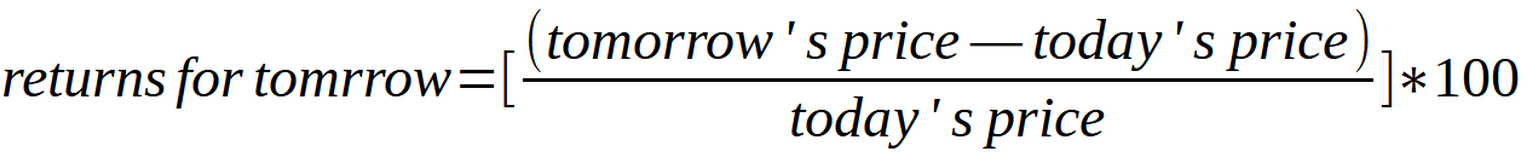

- "if you buy TODAY, this will be your returns for TOMORROW"
- we use the 'Returns 4 Tomorrow' to determine whether is GOOD or NO GOOD.
- If the Returns is positive, its GOOD.
- If the Returns is Negative, its BAD.
- in other words, we are going to use the Returns as a labelled indicator to train the model (to predict whether to buy or not).


,Close,PCT_CHANGE,VOLATILITY,SMA,CORR,Returns_4_Tmrw
Date,,,,,,
2022-01-03,301.209991,NaN,NaN,NaN,NaN,-0.027589
2022-01-04,292.899994,-0.027589,NaN,NaN,NaN,-0.057562
2022-01-05,276.040009,-0.057562,NaN,NaN,NaN,0.020794
2022-01-06,281.779999,0.020794,NaN,NaN,NaN,-0.033040
2022-01-07,272.470001,-0.033040,NaN,NaN,NaN,0.005615
...,...,...,...,...,...,...
2023-09-14,455.809998,0.002111,1.906214,469.500715,-0.427138,-0.036879
2023-09-15,439.000000,-0.036879,2.042995,467.987858,-0.587061,0.001503
2023-09-18,439.660004,0.001503,1.959447,465.938572,-0.682299,-0.010144


<Axes: xlabel='Date'>

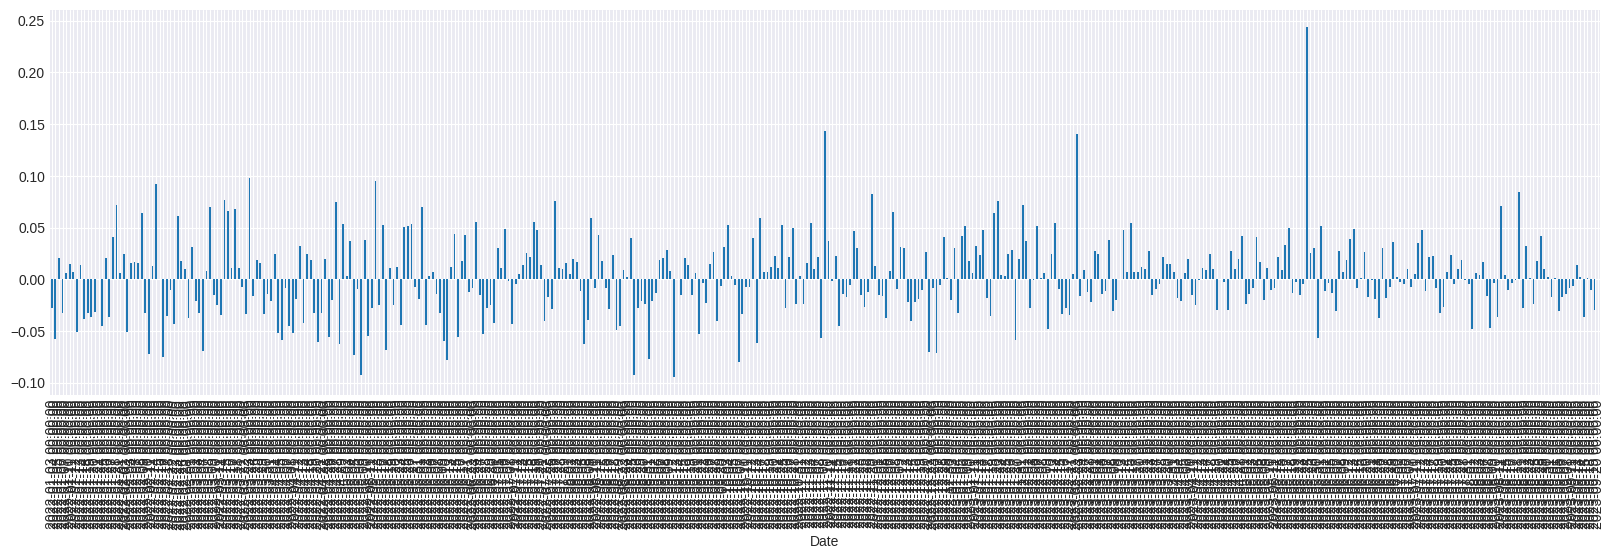

In [9]:
# Define Target (y)
data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)
display(data)
#notice a new column 'Returns_4_Tmrw' has been created

data['Returns_4_Tmrw'].plot(kind='bar', figsize=(20,5))



---



###2) Creating the Signal

##np.where()
- If data['Returns_4_Tmrw'] > 0, then Signal will turn 1, else 0.
- 1: Means GOOD = BUY.
- 0: Means BAD = Don't BUY.
- in other words, the Returns column is the "labelled data" used for training

In [10]:
data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)
display(data)

#notice a new column 'signal' has been created
#1 means BUY for that day
#0 means DON'T BUY for that day

,Close,PCT_CHANGE,VOLATILITY,SMA,CORR,Returns_4_Tmrw,Actual_Signal
Date,,,,,,,
2022-01-03,301.209991,NaN,NaN,NaN,NaN,-0.027589,0
2022-01-04,292.899994,-0.027589,NaN,NaN,NaN,-0.057562,0
2022-01-05,276.040009,-0.057562,NaN,NaN,NaN,0.020794,1
2022-01-06,281.779999,0.020794,NaN,NaN,NaN,-0.033040,0
2022-01-07,272.470001,-0.033040,NaN,NaN,NaN,0.005615,1
...,...,...,...,...,...,...,...
2023-09-14,455.809998,0.002111,1.906214,469.500715,-0.427138,-0.036879,0
2023-09-15,439.000000,-0.036879,2.042995,467.987858,-0.587061,0.001503,1
2023-09-18,439.660004,0.001503,1.959447,465.938572,-0.682299,-0.010144,0




---



#Step 4: Train Test Split

##4a) Display y and X

In [11]:
y, X = get_target_features(data)

In [12]:
y.head()

Date
2022-02-09    0
2022-02-10    0
2022-02-11    1
2022-02-14    1
2022-02-15    1
Name: Actual_Signal, dtype: int64

In [13]:
X.head()

,VOLATILITY,CORR
Date,,
2022-02-09,3.806067,-0.655315
2022-02-10,3.813065,-0.718135
2022-02-11,4.379243,-0.773518
2022-02-14,4.164786,-0.730634
2022-02-15,4.742134,-0.537833


##4b) Split 80% for Training and 20% for Testing

In [14]:
split = int(0.8*len(X))
#80% of the total number of rows

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
#X[:split] means from row 0 to row number 'split'
#X[split:] means from row 'split' until the last row



---



#Step 5: Use StandardScaler() to Scale the X

##5a) Import the StandardScaler()

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##5b) Scale X_train and X_test

In [16]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**sc.fit_transform(X_train): **
- The scaling parameters are learned from the training data and are stored in the scaler object.

**sc.transform(X_test): **
- This method transforms the test data using the scaling parameters that were learned from the training data.
- The test data is not scaled again, because this would introduce noise into the data.

**In general, **
- Use **sc.fit_transform(X_train)** on the training data and then use **sc.transform(X_test)** on the test data.

- This will ensure that the training and test data are scaled in the same way and that the model makes accurate predictions on the test data.



---



#Step 6: Import Logistic Regression Model and Start Training

##6a) Importing and Training

In [17]:
model = LogisticRegression()
model = model.fit(X_train,y_train)

##6b) Predicting y_pred

In [18]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

##6c) Showing the Probabilities for 0 and 1

In [19]:
probability = model.predict_proba(X_test)
print(probability)

[[0.43178869 0.56821131]
 [0.60579255 0.39420745]
 [0.6063146  0.3936854 ]
 [0.6023264  0.3976736 ]
 [0.61570791 0.38429209]
 [0.61481802 0.38518198]
 [0.61506213 0.38493787]
 [0.61652376 0.38347624]
 [0.6184786  0.3815214 ]
 [0.62270388 0.37729612]
 [0.62043717 0.37956283]
 [0.61839376 0.38160624]
 [0.61697823 0.38302177]
 [0.61438247 0.38561753]
 [0.61350145 0.38649855]
 [0.46455362 0.53544638]
 [0.4640394  0.5359606 ]
 [0.46444967 0.53555033]
 [0.44551576 0.55448424]
 [0.43493803 0.56506197]
 [0.43722515 0.56277485]
 [0.44685286 0.55314714]
 [0.44868424 0.55131576]
 [0.44314939 0.55685061]
 [0.43945253 0.56054747]
 [0.44286342 0.55713658]
 [0.4387528  0.5612472 ]
 [0.42937471 0.57062529]
 [0.41511101 0.58488899]
 [0.41595787 0.58404213]
 [0.41663955 0.58336045]
 [0.41378295 0.58621705]
 [0.42342242 0.57657758]
 [0.43813673 0.56186327]
 [0.4374556  0.5625444 ]
 [0.42579414 0.57420586]
 [0.4246118  0.5753882 ]
 [0.42124632 0.57875368]
 [0.43118045 0.56881955]
 [0.43090299 0.56909701]




---



#Step 7: Confusion Matrix and Accuracy Metric

In [20]:
def get_metrics(y_test, predicted):
    confusion_matrix_data = metrics.confusion_matrix(y_test, predicted)
    # Plot the data

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix_data, fmt="d",cmap='Blues', cbar=False, annot=True, ax=ax)

    # Set the axes labels and the title
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('Actual Labels', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
    ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

    # Display the plot
    plt.show()

    print('\n\n\n',metrics.classification_report(y_test, predicted))


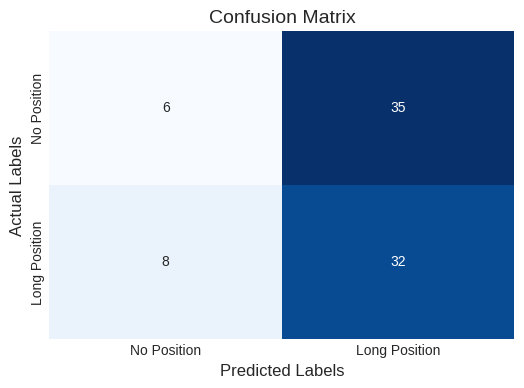




               precision    recall  f1-score   support

           0       0.43      0.15      0.22        41
           1       0.48      0.80      0.60        40

    accuracy                           0.47        81
   macro avg       0.45      0.47      0.41        81
weighted avg       0.45      0.47      0.41        81



In [21]:
get_metrics(y_test, y_pred)

In [21]:
#if the Accuracy (placed below the f1-score) is low... try
#1) putting in more metrics like SMA and Corr
#2) shortening the time period of testing
#3) change the ML model?



---



#Step 8: Backtesting Our Model

##8a) Obtaining our Backtest Data

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2016-01-04,8.092500
2016-01-05,8.222500
2016-01-06,7.882500
2016-01-07,7.570000
2016-01-08,7.407500
...,...
2016-12-23,27.445000
2016-12-27,29.330000
2016-12-28,27.312500


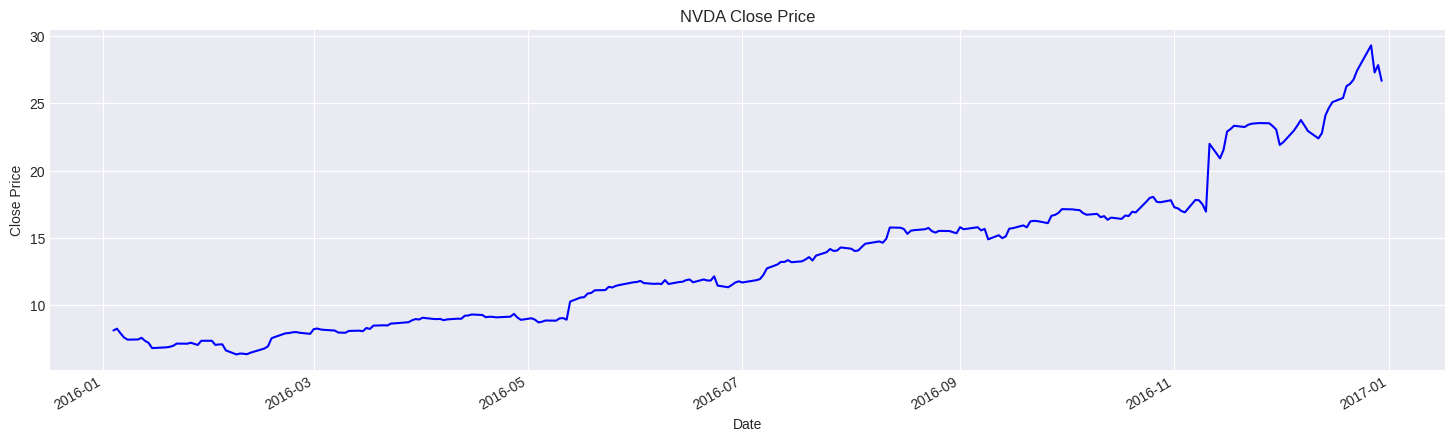

In [22]:
ticker = 'NVDA'
df = yf.download(ticker,start='2016-01-01', end='2017-01-01')
#we change the dates
#and is no longer called "data" but "df"

#we only want the Close price
df = pd.DataFrame(df['Close'])
display(df)

#Plot---------------------------------------
df.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()

##8b) Creating the Volatility and Correlation Columns as Features

In [23]:
#Create Volatility-----------------------------------------------
df['PCT_CHANGE'] = df['Close'].pct_change()
df['VOLATILITY'] = df.rolling(14)['PCT_CHANGE'].std()*100

#Create Correlation----------------------------------------------
df['SMA'] = ta.SMA(df['Close'],14)
df['CORR'] = ta.CORREL(df['Close'], df['SMA'], 14)

df = df.dropna()

#Create a temp_df to slice out only Volatility and Correlation
#temp_df = df[['VOLATILITY','CORR']]

display(df)

,Close,PCT_CHANGE,VOLATILITY,SMA,CORR
Date,,,,,
2016-02-10,6.357500,-0.002354,2.824878,6.921607,0.679820
2016-02-11,6.325000,-0.005112,2.696902,6.865357,0.791364
2016-02-12,6.432500,0.016996,2.774704,6.817321,0.833210
2016-02-16,6.747500,0.048970,3.128733,6.786786,0.722197
2016-02-17,6.915000,0.024824,3.209720,6.774286,0.568203
...,...,...,...,...,...
2016-12-23,27.445000,0.024928,2.163977,24.635893,0.892453
2016-12-27,29.330000,0.068683,2.628306,25.063214,0.931031
2016-12-28,27.312500,-0.068786,3.481384,25.316428,0.890133


##8c) Scale and Predict

In [24]:
df_scaled = sc.transform(df[['VOLATILITY','CORR']])

In [25]:
#Create a New Column
df['predicted_signal_4_tmrw'] = model.predict(df_scaled)

display(df)

,Close,PCT_CHANGE,VOLATILITY,SMA,CORR,predicted_signal_4_tmrw
Date,,,,,,
2016-02-10,6.357500,-0.002354,2.824878,6.921607,0.679820,1
2016-02-11,6.325000,-0.005112,2.696902,6.865357,0.791364,1
2016-02-12,6.432500,0.016996,2.774704,6.817321,0.833210,1
2016-02-16,6.747500,0.048970,3.128733,6.786786,0.722197,1
2016-02-17,6.915000,0.024824,3.209720,6.774286,0.568203,1
...,...,...,...,...,...,...
2016-12-23,27.445000,0.024928,2.163977,24.635893,0.892453,1
2016-12-27,29.330000,0.068683,2.628306,25.063214,0.931031,1
2016-12-28,27.312500,-0.068786,3.481384,25.316428,0.890133,1


##8d) Create the Buying Strategy

- Prediction is for the next day (based on features given for today).
- If we predict a 0 for tomorrow, we don't buy and have 0 Returns.
- **if we predict a 1 for tomorrow, we buy and we expect a Returns of 1 x tomorrow's PCT_CHANGE **

In [26]:
# Calculate the Next Day's strategy returns
df['strategy_returns'] = df['predicted_signal_4_tmrw'].shift(1) * df['PCT_CHANGE']

# Drop the missing values
df.dropna(inplace=True)

display(df)

,Close,PCT_CHANGE,VOLATILITY,SMA,CORR,predicted_signal_4_tmrw,strategy_returns
Date,,,,,,,
2016-02-11,6.325000,-0.005112,2.696902,6.865357,0.791364,1,-0.005112
2016-02-12,6.432500,0.016996,2.774704,6.817321,0.833210,1,0.016996
2016-02-16,6.747500,0.048970,3.128733,6.786786,0.722197,1,0.048970
2016-02-17,6.915000,0.024824,3.209720,6.774286,0.568203,1,0.024824
2016-02-18,7.510000,0.086045,3.947517,6.809821,0.288630,1,0.086045
...,...,...,...,...,...,...,...
2016-12-23,27.445000,0.024928,2.163977,24.635893,0.892453,1,0.024928
2016-12-27,29.330000,0.068683,2.628306,25.063214,0.931031,1,0.068683
2016-12-28,27.312500,-0.068786,3.481384,25.316428,0.890133,1,-0.068786


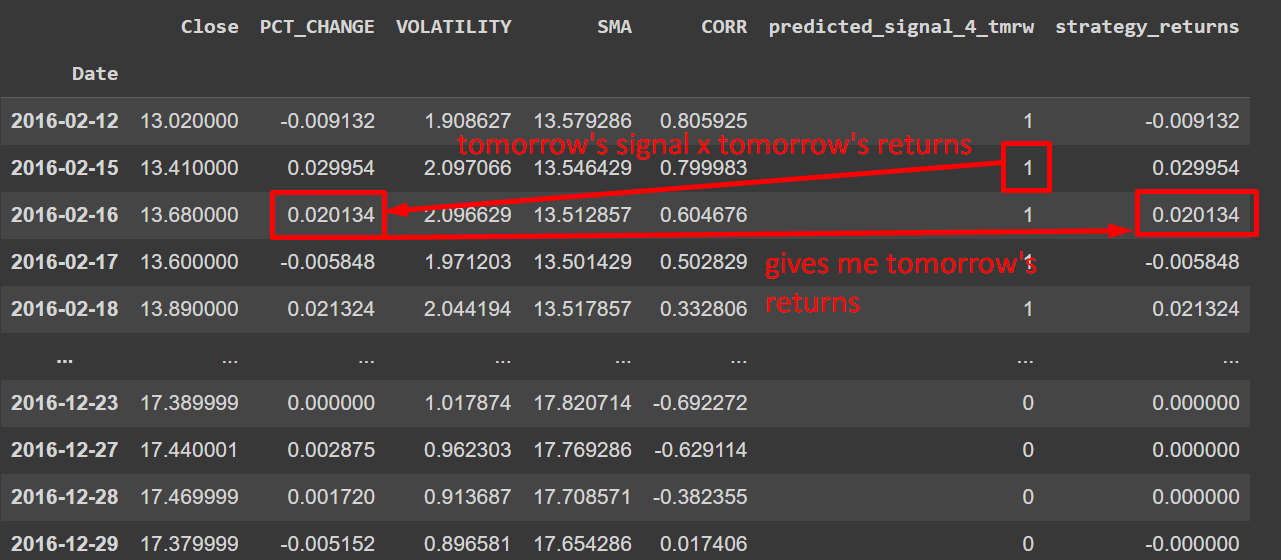

In [27]:
pf.create_simple_tear_sheet(df['strategy_returns'])

AttributeError: 'Series' object has no attribute 'iteritems'



---

#THE END



---

